In [1]:
import scanpy as sc
from pathlib import Path
import pandas as pd
import os
import re
import numpy as np
import anndata as ad
from tqdm import tqdm
import squidpy as sq

from joblib import Parallel, delayed
import squidpy as sq
import scanpy as sc
from anndata import AnnData
from scipy.sparse import csr_matrix

%load_ext autoreload
%autoreload 2
%load_ext lab_black

path_read = Path("/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data")

In [2]:
from pathlib import Path

path_data = "/lustre/groups/ml01/workspace/giovanni.palla/moscot/processed_data"
dataset = 21
seed = 10
adata_sp = ad.read(Path(path_data) / f"dataset{dataset}_sp.h5ad")
rng = np.random.default_rng(seed)
if "highly_variable" in adata_sp.var.columns:
    adata_sp = adata_sp[:, adata_sp.var.highly_variable].copy()
    n_genes = 100
else:
    n_genes = 10

adata_sp_a = sc.pp.subsample(adata_sp, fraction=0.5, copy=True, random_state=seed)
adata_sp_b = adata_sp[~np.in1d(adata_sp.obs_names, adata_sp_a.obs_names)].copy()

test_var = rng.choice(adata_sp.var_names, n_genes, replace=False).tolist()
train_var = adata_sp_a.var_names[~np.in1d(adata_sp_a.var_names, test_var)].tolist()
true_df = sc.get.obs_df(adata_sp_b, keys=test_var)

adata_sp_a_train = adata_sp_a[:, train_var].copy()
adata_sp_b_train = adata_sp_b[:, train_var].copy()

sc.tl.pca(adata_sp_b_train)
sc.tl.pca(adata_sp_a_train)
adata_sp_a.obsm["X_pca"] = adata_sp_a_train.obsm["X_pca"].copy()

In [3]:
adata_sc = adata_sp_a
adata_sp_train = adata_sp_b_train

In [4]:
import tangram as tg
import torch

tg.pp_adatas(adata_sc, adata_sp_train, genes=true_df.columns.tolist())
device = torch.device("cuda")

ad_map = tg.map_cells_to_space(adata_sc, adata_sp_train, device=device)
ad_ge = tg.project_genes(ad_map, adata_sc)

INFO:root:0 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:1887 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 0 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


KL reg: 0.020
KL reg: 0.000
KL reg: -0.000
KL reg: -0.000
KL reg: -0.000
KL reg: -0.000
KL reg: -0.000
KL reg: -0.000
KL reg: -0.000
KL reg: -0.000


INFO:root:Saving results..


In [5]:
ad_map.uns["training_history"]["kl_reg"][-1]

'-4.2220115403779346e-08'

In [6]:
true_df.columns = [a.lower() for a in true_df.columns]
pred_df = sc.get.obs_df(ad_ge, keys=true_df.columns.tolist())

In [7]:
corr_pearson = pred_df.corrwith(true_df, method="pearson")
corr_spearman = pred_df.corrwith(true_df, method="spearman")

In [8]:
out = pd.concat([corr_pearson, corr_spearman], axis=1)
out.columns = ["pearson", "spearman"]

In [9]:
out.max(0)

pearson     0.783257
spearman    0.716448
dtype: float64

In [11]:
out.mean(0)

pearson     0.096320
spearman    0.103914
dtype: float64

In [13]:
out

,pearson,spearman
clnk,0.032607,0.034496
pde8b,0.020605,0.023644
bzw2,0.425696,0.408126
kcng1,-0.016592,-0.004646
cd22,-0.031593,-0.028130
...,...,...
cks1b,0.483934,0.444237
cytl1,-0.018972,-0.011693
impa2,0.384831,0.397357
serpinb9,0.062297,0.074712


In [14]:
ad_ge.obsm["spatial"] = adata_sp_b.obsm["spatial"].copy()

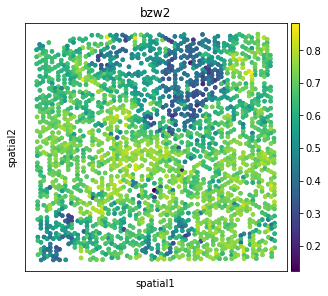

In [20]:
sq.pl.spatial_scatter(ad_ge, color=["bzw2"], shape=None)

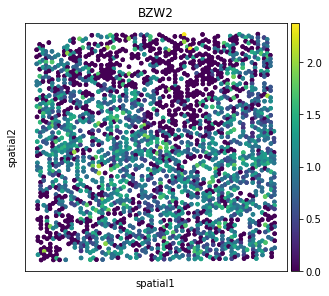

In [18]:
sq.pl.spatial_scatter(adata_sp_b, color=["BZW2"], shape=None)